In [135]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score
import optuna
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [136]:
# Load the dataset
df = pd.read_csv('Data-Melbourne_F_fixed.csv')

# Combine Year, Month, and Day into a single Date column and drop individual columns
df['Datetime'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
df = df.drop(columns=['Year', 'Month', 'Day'])

first_column = df.pop('Datetime')
df.insert(0, 'Datetime', first_column)

if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

# Split into features and target
X = df.drop(columns=['Energy Consumption'])  # All columns except 'Energy Consumption'
y = df['Energy Consumption']  # Target column 'Energy Consumption'

# Display the DataFrame and its info
display(df)
df.info()

,Datetime,Average Outflow,Average Inflow,Energy Consumption,Ammonia,Biological Oxygen Demand,Chemical Oxygen Demand,Total Nitrogen,Average Temperature,Maximum temperature,Minimum temperature,Atmospheric pressure,Average humidity,Total rainfall,Average visibility,Average wind speed,Maximum wind speed
0,2014-01-01,2.941,2.589,175856.0,27.0,365.0,730.0,60.378,19.3,25.1,12.6,0.0,56.0,1.52,10.0,26.9,53.5
1,2014-01-02,2.936,2.961,181624.0,25.0,370.0,740.0,60.026,17.1,23.6,12.3,0.0,63.0,0.00,10.0,14.4,27.8
2,2014-01-05,2.928,3.225,202016.0,42.0,418.0,836.0,64.522,16.8,27.2,8.8,0.0,47.0,0.25,10.0,31.9,61.1
3,2014-01-06,2.928,3.354,207547.0,36.0,430.0,850.0,63.000,14.6,19.9,11.1,0.0,49.0,0.00,10.0,27.0,38.9
4,2014-01-07,2.917,3.794,202824.0,46.0,508.0,1016.0,65.590,13.4,19.1,8.0,0.0,65.0,0.00,10.0,20.6,35.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1377,2019-06-20,5.068,4.716,305938.0,28.0,310.0,660.0,58.807,6.8,10.0,4.0,0.0,56.0,0.00,10.0,14.4,22.2
1378,2019-06-24,5.882,5.510,293446.0,40.0,250.0,700.0,60.671,7.6,16.0,3.0,0.0,71.0,0.00,0.0,13.5,25.9
1379,2019-06-25,4.638,4.811,307968.0,47.0,260.0,860.0,64.000,9.7,16.0,3.0,0.0,65.0,0.00,10.0,18.1,25.9
1380,2019-06-26,5.373,4.929,316675.0,46.0,300.0,900.0,62.479,10.9,17.0,5.0,0.0,65.0,0.00,10.0,21.9,35.2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1382 entries, 0 to 1381
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Datetime                  1382 non-null   datetime64[ns]
 1   Average Outflow           1382 non-null   float64       
 2   Average Inflow            1382 non-null   float64       
 3   Energy Consumption        1382 non-null   float64       
 4   Ammonia                   1382 non-null   float64       
 5   Biological Oxygen Demand  1382 non-null   float64       
 6   Chemical Oxygen Demand    1382 non-null   float64       
 7   Total Nitrogen            1382 non-null   float64       
 8   Average Temperature       1382 non-null   float64       
 9   Maximum temperature       1382 non-null   float64       
 10  Minimum temperature       1382 non-null   float64       
 11  Atmospheric pressure      1382 non-null   float64       
 12  Average humidity    

In [137]:
# Split the data into training (80%) and testing (20%) sets
train_size = int(0.8 * len(df))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Drop the 'Datetime' column before scaling
X_train_scaled = X_train.drop(columns=['Datetime'])
X_test_scaled = X_test.drop(columns=['Datetime'])

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_scaled)
X_test_scaled = scaler.transform(X_test_scaled)

# Adding the 'Datetime' column back to the scaled DataFrames for future use
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns.drop('Datetime'))
X_train_scaled_df['Datetime'] = X_train['Datetime'].values

X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns.drop('Datetime'))
X_test_scaled_df['Datetime'] = X_test['Datetime'].values

# Convert the scaled DataFrames back to numpy arrays for model training
X_train_scaled = X_train_scaled_df.drop(columns=['Datetime']).values
X_test_scaled = X_test_scaled_df.drop(columns=['Datetime']).values

In [138]:
# Define the model creation function
def create_model(trial):
    model_type = trial.suggest_categorical('model_type', ['KRR', 'KNN', 'SVR', 'RF', 'GBM'])
    
    if model_type == 'KRR':
        alpha = trial.suggest_loguniform('krr_alpha', 1e-3, 1e1)
        kernel = trial.suggest_categorical('krr_kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
        degree = trial.suggest_int('krr_degree', 2, 5)
        coef0 = trial.suggest_uniform('krr_coef0', 0, 1)
        model = KernelRidge(alpha=alpha, kernel=kernel, degree=degree, coef0=coef0)
    
    elif model_type == 'KNN':
        n_neighbors = trial.suggest_int('knn_n_neighbors', 2, 50)
        weights = trial.suggest_categorical('knn_weights', ['uniform', 'distance'])
        model = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights)
    
    elif model_type == 'SVR':
        C = trial.suggest_loguniform('svr_C', 1e-3, 1e2)
        epsilon = trial.suggest_loguniform('svr_epsilon', 1e-3, 1e1)
        kernel = trial.suggest_categorical('svr_kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
        degree = trial.suggest_int('svr_degree', 2, 5)
        coef0 = trial.suggest_uniform('svr_coef0', 0, 1)
        model = SVR(C=C, epsilon=epsilon, kernel=kernel, degree=degree, coef0=coef0)
    
    elif model_type == 'RF':
        n_estimators = trial.suggest_int('rf_n_estimators', 50, 200)
        max_depth = trial.suggest_int('rf_max_depth', 2, 20)
        model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
    
    elif model_type == 'GBM':
        n_estimators = trial.suggest_int('gbm_n_estimators', 50, 200)
        learning_rate = trial.suggest_loguniform('gbm_learning_rate', 1e-3, 1e-1)
        max_depth = trial.suggest_int('gbm_max_depth', 2, 20)
        model = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth)
    
    return model

# Define the objective function
def objective(trial):
    model = create_model(trial)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    return rmse

# Optimize the hyperparameters using Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, timeout=600)

# Define hyperparameters for each model type to use with FixedTrial
model_params = {
    'KRR': {'krr_alpha': 0.1, 'krr_kernel': 'rbf', 'krr_degree': 3, 'krr_coef0': 0.5},
    'KNN': {'knn_n_neighbors': 10, 'knn_weights': 'distance'},
    'SVR': {'svr_C': 1.0, 'svr_epsilon': 0.1, 'svr_kernel': 'rbf', 'svr_degree': 3, 'svr_coef0': 0.0},
    'RF': {'rf_n_estimators': 100, 'rf_max_depth': 10},
    'GBM': {'gbm_n_estimators': 100, 'gbm_learning_rate': 0.05, 'gbm_max_depth': 5},
}

# Print the best model and its parameters
best_model_params = study.best_trial.params
best_model_type = best_model_params['model_type']
print(f"Best Model: {best_model_type}")
print(f"Best Model Parameters: {best_model_params}")

# Evaluate all models
model_types = ['KRR', 'KNN', 'SVR', 'RF', 'GBM']
results = []

for model_type in model_types:
    trial = optuna.trial.FixedTrial({'model_type': model_type, **model_params[model_type]})
    model = create_model(trial)
    model.fit(X_train_scaled, y_train)
    
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    metrics = {
        'Model Type': model_type,
        'Dataset': 'Train',
        'RMSE': mean_squared_error(y_train, y_train_pred, squared=False),
        'MAE': mean_absolute_error(y_train, y_train_pred),
        'MSLE': mean_squared_log_error(y_train, y_train_pred),
        'R^2': r2_score(y_train, y_train_pred)
    }
    results.append(metrics)
    
    metrics = {
        'Model Type': model_type,
        'Dataset': 'Test',
        'RMSE': mean_squared_error(y_test, y_test_pred, squared=False),
        'MAE': mean_absolute_error(y_test, y_test_pred),
        'MSLE': mean_squared_log_error(y_test, y_test_pred),
        'R^2': r2_score(y_test, y_test_pred)
    }
    results.append(metrics)

[I 2024-06-17 10:41:04,007] A new study created in memory with name: no-name-26172675-326f-42f3-980a-5da61aecfcad
C:\Users\HomePC\Desktop\ChE297_FP\env\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-17 10:41:04,388] Trial 0 finished with value: 38906.68316176499 and parameters: {'model_type': 'RF', 'rf_n_estimators': 103, 'rf_max_depth': 4}. Best is trial 0 with value: 38906.68316176499.
C:\Users\HomePC\Desktop\ChE297_FP\env\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-17 10:41:05,531] Trial 1 finished with value: 38263.44415589545 and parameters: {'model_type': 'RF', 'rf_n_estimators': 

Best Model: GBM
Best Model Parameters: {'model_type': 'GBM', 'gbm_n_estimators': 170, 'gbm_learning_rate': 0.004380265227083787, 'gbm_max_depth': 9}


C:\Users\HomePC\Desktop\ChE297_FP\env\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\HomePC\Desktop\ChE297_FP\env\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\HomePC\Desktop\ChE297_FP\env\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\HomePC\Desktop\ChE297_FP\env\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6

In [139]:
# Create a results DataFrame
results_df = pd.DataFrame(results)
display(results_df)

,Model Type,Dataset,RMSE,MAE,MSLE,R^2
0,KRR,Train,29473.312121,22756.482928,0.013111,0.589125
1,KRR,Test,61557.268679,43226.114431,0.121645,-1.557433
2,KNN,Train,0.000000,0.000000,0.000000,1.000000
3,KNN,Test,40772.971041,31781.738425,0.023547,-0.121993
4,SVR,Train,45973.951151,36823.175437,0.031137,0.000288
5,SVR,Test,38734.483332,30852.088325,0.020804,-0.012607
6,RF,Train,20183.100826,16076.971356,0.006329,0.807324
7,RF,Test,38294.775824,29927.306439,0.021015,0.010252
8,GBM,Train,24567.806878,19275.972243,0.009195,0.714514
9,GBM,Test,39340.487270,30427.160722,0.022129,-0.044540


C:\Users\HomePC\AppData\Local\Temp\ipykernel_14660\2051129798.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('gbm_learning_rate', 1e-3, 1e-1)


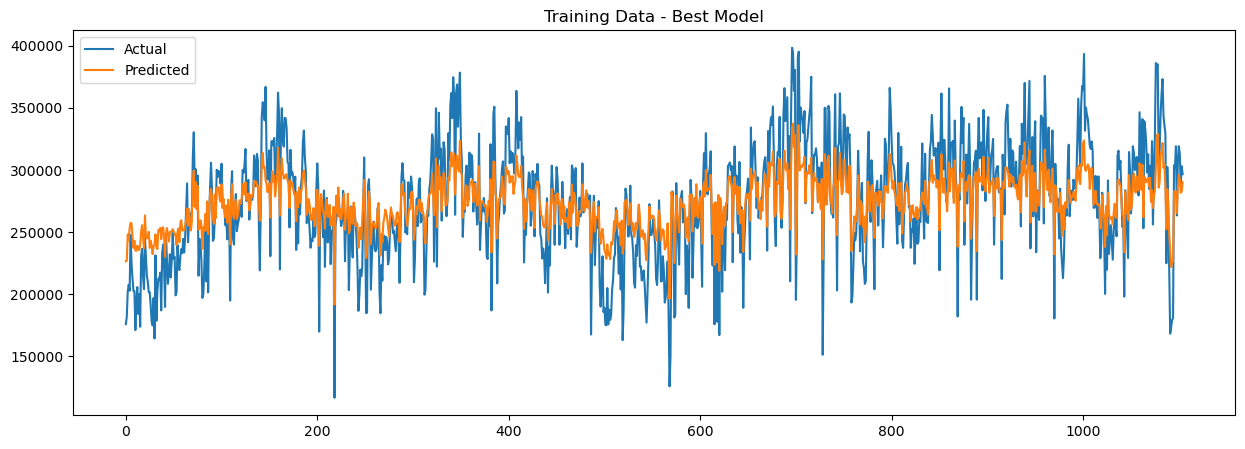

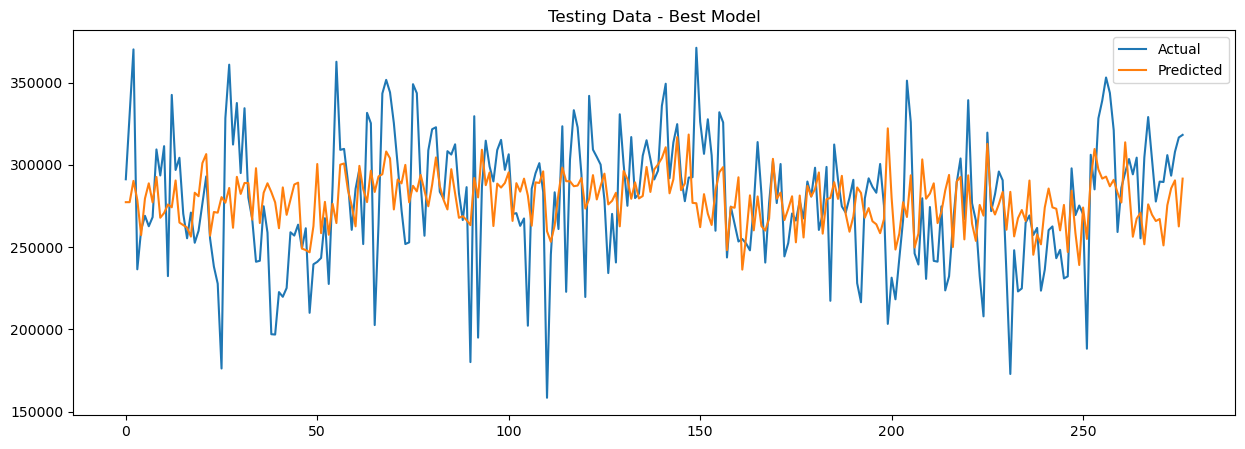

C:\Users\HomePC\Desktop\ChE297_FP\env\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\HomePC\Desktop\ChE297_FP\env\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\HomePC\AppData\Local\Temp\ipykernel_14660\2051129798.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('krr_alpha', 1e-3, 1e1)
C:\Users\HomePC\AppData\Local\Temp\ipykernel_14660\2051129798.py:9: FutureWarning: suggest_uniform has been deprecat

Performance Metrics for Training Data - Best Model:
RMSE: 26674.202389742677
MAE: 21273.147563955692
MSLE: 0.011034267228745084
R^2: 0.663461853340148

Performance Metrics for Testing Data - Best Model:
RMSE: 36306.011715909575
MAE: 28190.709011688923
MSLE: 0.018704374813417902
R^2: 0.11038383979463795



C:\Users\HomePC\AppData\Local\Temp\ipykernel_14660\2051129798.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('gbm_learning_rate', 1e-3, 1e-1)


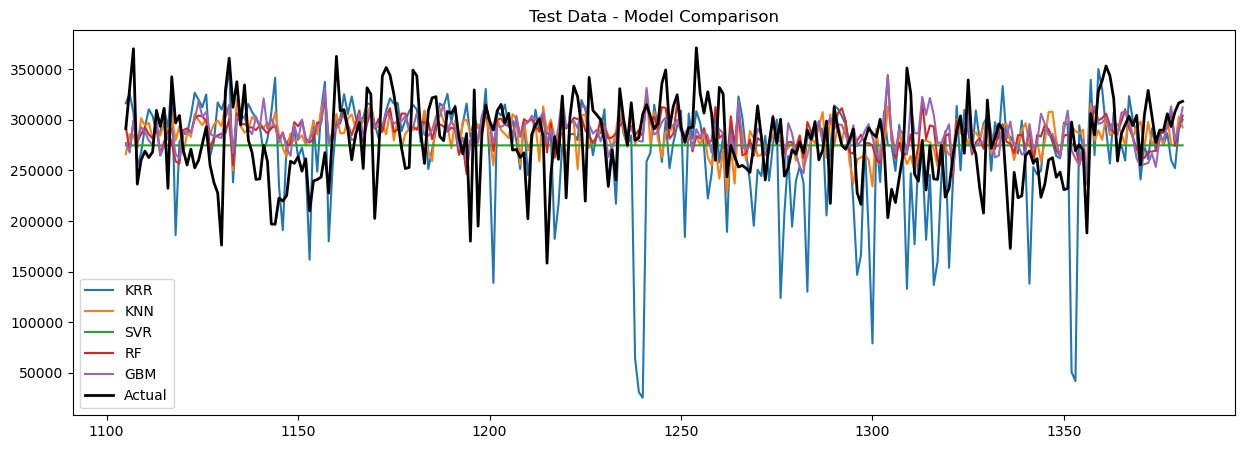

C:\Users\HomePC\AppData\Local\Temp\ipykernel_14660\2051129798.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('krr_alpha', 1e-3, 1e1)
C:\Users\HomePC\AppData\Local\Temp\ipykernel_14660\2051129798.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  coef0 = trial.suggest_uniform('krr_coef0', 0, 1)
C:\Users\HomePC\AppData\Local\Temp\ipykernel_14660\2051129798.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('svr_C', 1e-3, 1e2)
C:\Users\HomePC\AppData\Local\Temp\ip

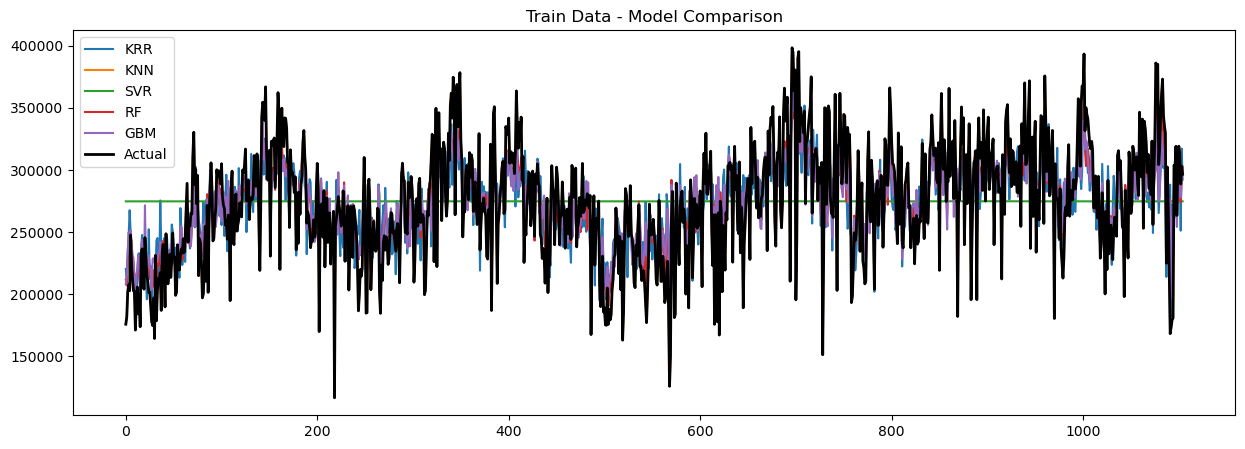

In [140]:
# Plot time series graph of energy consumption
def plot_time_series(y_true, y_pred, title):
    plt.figure(figsize=(15, 5))
    plt.plot(y_true, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title(title)
    plt.legend()
    plt.show()

# Plot for the best model (from the study)
best_model_type = study.best_trial.params['model_type']
best_trial = optuna.trial.FixedTrial(study.best_trial.params)
best_model = create_model(best_trial)
best_model.fit(X_train_scaled, y_train)

y_train_pred_best = best_model.predict(X_train_scaled)
y_test_pred_best = best_model.predict(X_test_scaled)

plot_time_series(y_train.values, y_train_pred_best, 'Training Data - Best Model')
plot_time_series(y_test.values, y_test_pred_best, 'Testing Data - Best Model')

# Display performance metrics for the best model
def display_metrics(y_true, y_pred, dataset_name):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    msle = mean_squared_log_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f'Performance Metrics for {dataset_name}:')
    print(f'RMSE: {rmse}')
    print(f'MAE: {mae}')
    print(f'MSLE: {msle}')
    print(f'R^2: {r2}')
    print('')

display_metrics(y_train, y_train_pred_best, 'Training Data - Best Model')
display_metrics(y_test, y_test_pred_best, 'Testing Data - Best Model')

# Plot all models for comparison (Test Data)
plt.figure(figsize=(15, 5))
for model_type in model_types:
    trial = optuna.trial.FixedTrial({'model_type': model_type, **model_params[model_type]})
    model = create_model(trial)
    model.fit(X_train_scaled, y_train)
    y_test_pred = model.predict(X_test_scaled)
    
    plt.plot(y_test.index, y_test_pred, label=model_type)

plt.plot(y_test.index, y_test.values, label='Actual', color='black', linewidth=2)
plt.title('Test Data - Model Comparison')
plt.legend()
plt.show()

# Plot all models for comparison (Train Data)
plt.figure(figsize=(15, 5))
for model_type in model_types:
    trial = optuna.trial.FixedTrial({'model_type': model_type, **model_params[model_type]})
    model = create_model(trial)
    model.fit(X_train_scaled, y_train)
    y_train_pred = model.predict(X_train_scaled)
    
    plt.plot(y_train.index, y_train_pred, label=model_type)

plt.plot(y_train.index, y_train.values, label='Actual', color='black', linewidth=2)
plt.title('Train Data - Model Comparison')
plt.legend()
plt.show()

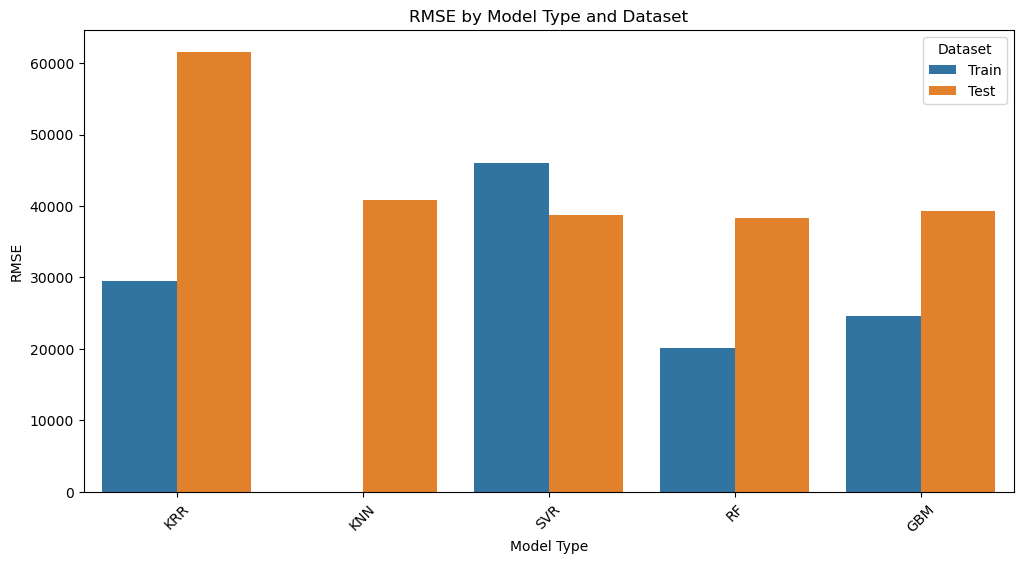

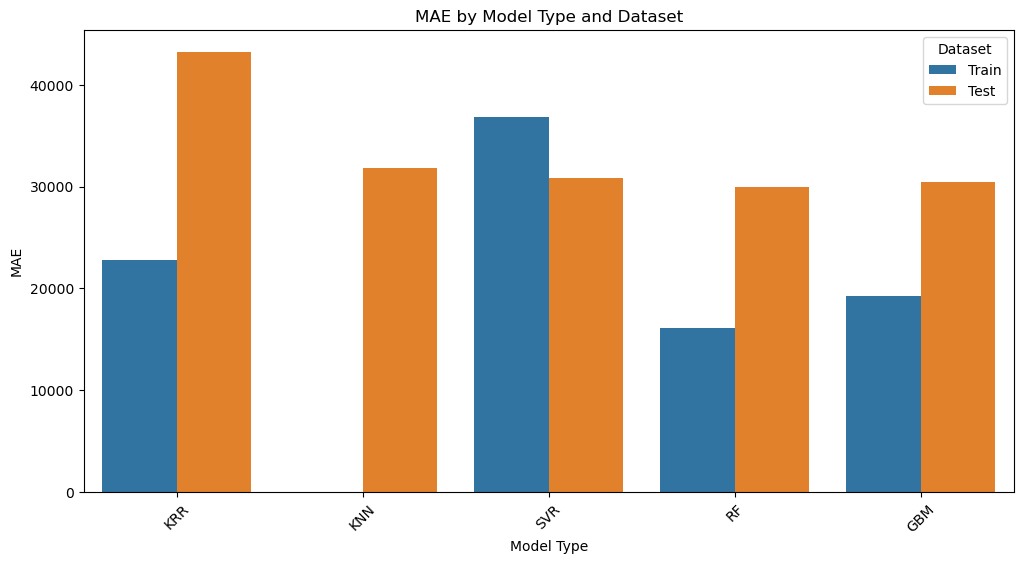

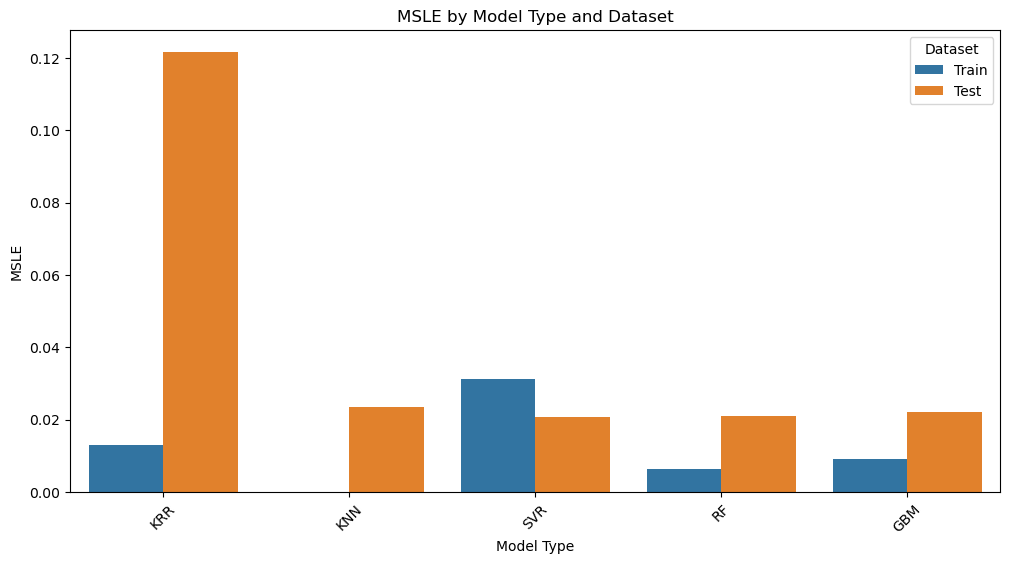

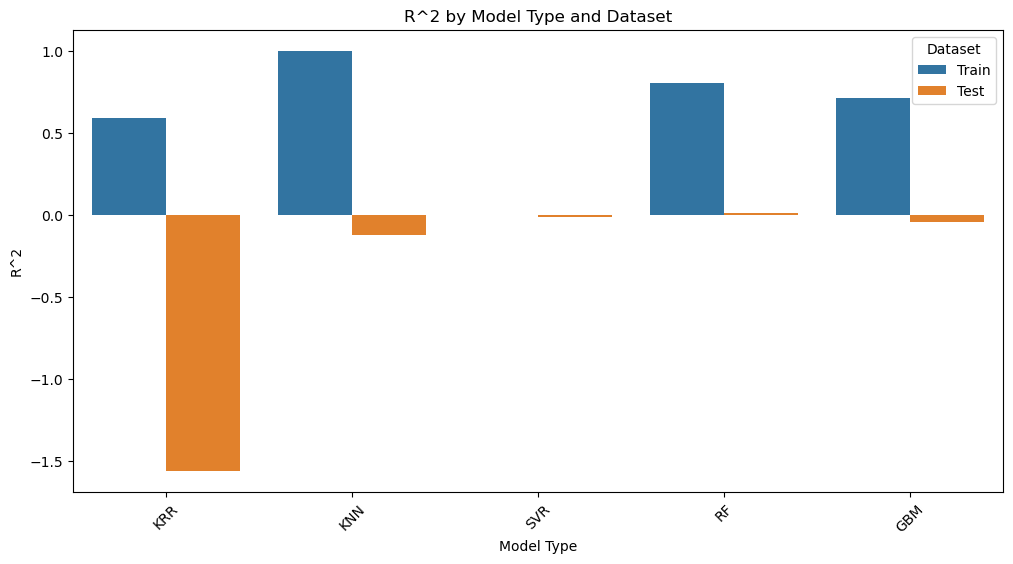

In [141]:
# Function to plot the performance metrics
def plot_performance_metrics(results_df, metric):
    plt.figure(figsize=(12, 6))
    sns.barplot(data=results_df, x='Model Type', y=metric, hue='Dataset')
    plt.title(f'{metric} by Model Type and Dataset')
    plt.ylabel(metric)
    plt.xlabel('Model Type')
    plt.legend(title='Dataset')
    plt.xticks(rotation=45)
    plt.show()

# Plot RMSE
plot_performance_metrics(results_df, 'RMSE')

# Plot MAE
plot_performance_metrics(results_df, 'MAE')

# Plot MSLE
plot_performance_metrics(results_df, 'MSLE')

# Plot R^2
plot_performance_metrics(results_df, 'R^2')

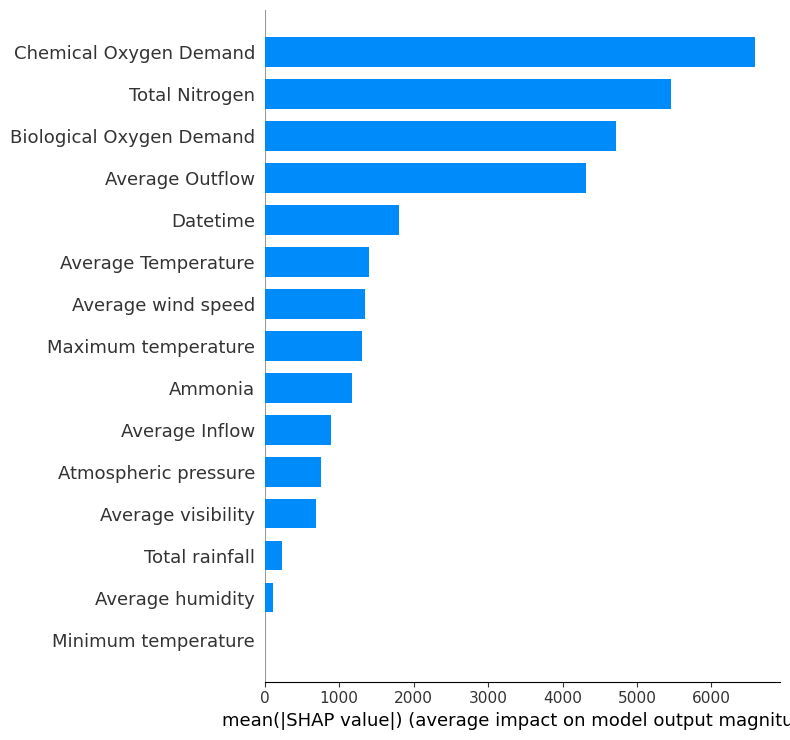

In [149]:
# Compute Shapley Values for the best model
explainer = shap.Explainer(best_model)
shap_values = explainer(X_train_scaled)

# Plot summary plot for the best model
shap.summary_plot(shap_values, X_train_scaled, feature_names=feature_names, plot_type='bar', title='Shapley Values - Best Model')
